In [35]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
import torch

import importlib
import data_preprocess_stance, train_stance, eval_stance  # after renaming file to evaluation_utils.py
import sys
import os
sys.path.append(os.path.abspath('..'))
import expandnrc_adapter
from expandnrc_adapter import preprocess_with_expandnrc   
importlib.reload(data_preprocess_stance)
importlib.reload(train_stance)
importlib.reload(eval_stance)
importlib.reload(expandnrc_adapter)


from data_preprocess_stance import  preprocess_data
from train_stance import train_model
# load_stance_model
from eval_stance import plot_training_history_cm_cr, load_training_results


it is with change


##### final sults saved for AMT1

In [6]:
dfMT1 = pd.read_json("../data/dfMT1_stance-v1.json") #1
dfMT2 = pd.read_json("../data/dfMT2_stance-v1.json") #2
dfIBM = pd.read_json("../data/dfIBM_stance-v1.json") #3
dfPC = pd.read_json("../data/dfPE_stance-v1.json") #4
dfUKB = pd.read_json("../data/dfUKB_stance-v1.json") #5

# MT1

In [7]:
dfMT1.head(2)

,EDU,stance,topic_id,Relations,Label,all_stance
0,"[Yes, it's annoying and cumbersome to separate your rubbish properly all the time., Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins., But still Germany produces way too much rubbish, and too many resources are lost when what actually should be separated and recycled is burnt., We Berliners should take the chance and become pioneers in waste separation!]","[Against, Against, For, For, For]",waste_separation,"[[a1, a5, reb], [a2, a1, sup], [a3, c1, und], [a4, c3, add]]","[0, 0, 0, 0, 1]",pro
1,"[One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt., And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles., Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners., Of course, first they'd actually need to be caught in the act by public order officers,, but once they have to dig into their pockets, their laziness will sure vanish!]","[For, For, For, Against, For]",higher_dog_poo_fines,"[[a1, a3, sup], [a2, a3, sup], [a4, a3, reb], [a5, c4, und]]","[0, 0, 1, 0, 0]",pro


### With Sampling
here, we keep the order of adu, feed to model row by row

In [8]:
X_train, X_test, y_train, y_test = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= True, test_size=0.2,random_state=41,)

In [9]:
X_train[0:2]

,text,topic_id,nrc_feats
39,"[There should be much higher fines for dog dirt left on pavements., Stepping in dog dirt is gross and absolutely ruins your day, due to the dirt, the stench and the often considerable effort to get rid of it., Besides, the fines for public urination by a human are higher than for leaving behind dog dirt on the pavement, which is disproportionate., Some dog owners assume that paying a dog licence fee covers the removal of such waste,, but according to this logic one could hardly make the taxpayer accountable for almost any offense.]",higher_dog_poo_fines,"[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 1, 1, 0]]"
57,"[Rent prices are already regulated in favour of tenants due to existing laws and the rent index., In view of the high prices for buying flats with existing rent contracts, these are an unattractive investment., Even if one might think that additional rent control is needed besides the current tenant protection,, one should not deny longstanding owners the opportunity to adjust their returns to market level., A cap on rent increases upon tenant change is therefore not to be supported.]",cap_rent_increases,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1]]"


In [10]:
y_train[0:2]

39    [1, 1, 1, 1, 0, 1]
57       [1, 1, 0, 1, 1]
Name: label, dtype: object

### With No Sampling (N)
here, we do not keep the order of adu, feed to model each adu

In [11]:
X_train_n, X_test_n, y_train_n, y_test_n = preprocess_data(dfMT1, use_nrc=True, include_topic=True, sample_level= False, test_size=0.2,random_state=41,)

In [12]:
X_train_n[0:2]

,text,topic_id,nrc_feats
3,and too many resources are lost when what actually should be separated and recycled is burnt.,waste_separation,"[1, 1, 0, 0, 1, 1, 0, 0]"
194,"due to the dirt, the stench and the often considerable effort to get rid of it.",higher_dog_poo_fines,"[0, 0, 0, 0, 0, 1, 0, 0]"


In [13]:
y_train_n[0:2]

3      1
194    1
Name: label, dtype: int64

## Train Stance  Classifier (N)

In [15]:
model_n, history_n, y_test_pred_n = train_model(
    X_train=(X_train_n['text'].tolist(), X_train_n['topic_id'].tolist()),
    y_train=y_train_n.tolist(),
    X_test=(X_test_n['text'].tolist(), X_test_n['topic_id'].tolist()),
    y_test=y_test_n.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=False,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_MT1_B4_E8.pt'
    )




Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8:   0%|          | 0/115 [00:00<?, ?it/s]


KeyboardInterrupt: 

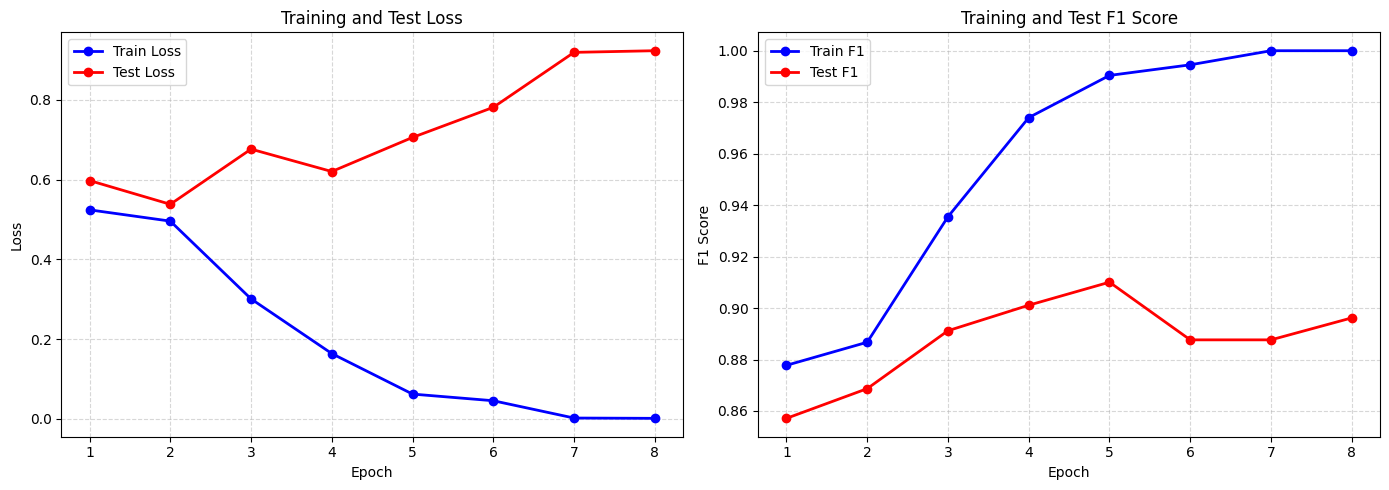

✅ Chart saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_charts.png

Confusion Matrix:
[[15 14]
 [ 5 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61        29
           1       0.85      0.94      0.90        87

    accuracy                           0.84       116
   macro avg       0.80      0.73      0.75       116
weighted avg       0.83      0.84      0.83       116

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_eval.txt


In [14]:
plot_training_history_cm_cr(history_n, y_true=y_test_n, y_pred=y_test_pred_n, run_name="./final_results/StanceClassification_Bert_MT1_B4_E8")


# Train Stance  Classifier 

In [15]:
model, history, y_test_pred= train_model(
    X_train=(X_train['text'].tolist(), X_train['topic_id'].tolist(), X_train['nrc_feats'].tolist()),
    y_train=y_train.tolist(),
    X_test=(X_test['text'].tolist(), X_test['topic_id'].tolist(), X_test['nrc_feats'].tolist()),
    y_test=y_test.tolist(),
    batch_size=4,
    epochs=8,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled.pt'
)


h:\moha\NLP\AM\SA\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/8: 100%|██████████| 115/115 [04:26<00:00,  2.31s/it]



Epoch 1/8
Train Loss: 0.5328, Train F1: 0.8790
Test Loss: 0.5284, F1: 0.8485, Precision: 0.8077, Recall: 0.8936
--------------------------------------------------


Epoch 2/8: 100%|██████████| 115/115 [04:13<00:00,  2.20s/it]



Epoch 2/8
Train Loss: 0.4340, Train F1: 0.8993
Test Loss: 0.5723, F1: 0.8952, Precision: 0.8103, Recall: 1.0000
--------------------------------------------------


Epoch 3/8: 100%|██████████| 115/115 [04:14<00:00,  2.21s/it]



Epoch 3/8
Train Loss: 0.2875, Train F1: 0.9384
Test Loss: 0.5808, F1: 0.9216, Precision: 0.8545, Recall: 1.0000
--------------------------------------------------


Epoch 4/8: 100%|██████████| 115/115 [04:40<00:00,  2.44s/it]



Epoch 4/8
Train Loss: 0.1248, Train F1: 0.9793
Test Loss: 0.8360, F1: 0.8945, Precision: 0.8476, Recall: 0.9468
--------------------------------------------------


Epoch 5/8: 100%|██████████| 115/115 [05:07<00:00,  2.67s/it]



Epoch 5/8
Train Loss: 0.0900, Train F1: 0.9902
Test Loss: 0.9120, F1: 0.9055, Precision: 0.8505, Recall: 0.9681
--------------------------------------------------


Epoch 6/8: 100%|██████████| 115/115 [04:25<00:00,  2.31s/it]



Epoch 6/8
Train Loss: 0.0170, Train F1: 0.9986
Test Loss: 1.2556, F1: 0.8718, Precision: 0.8416, Recall: 0.9043
--------------------------------------------------


Epoch 7/8: 100%|██████████| 115/115 [04:32<00:00,  2.37s/it]



Epoch 7/8
Train Loss: 0.0288, Train F1: 0.9972
Test Loss: 1.2544, F1: 0.8808, Precision: 0.8586, Recall: 0.9043
--------------------------------------------------


Epoch 8/8: 100%|██████████| 115/115 [04:29<00:00,  2.35s/it]



Epoch 8/8
Train Loss: 0.0166, Train F1: 0.9986
Test Loss: 1.3071, F1: 0.8808, Precision: 0.8586, Recall: 0.9043
--------------------------------------------------
✅ Full model checkpoint saved to: ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled.pt


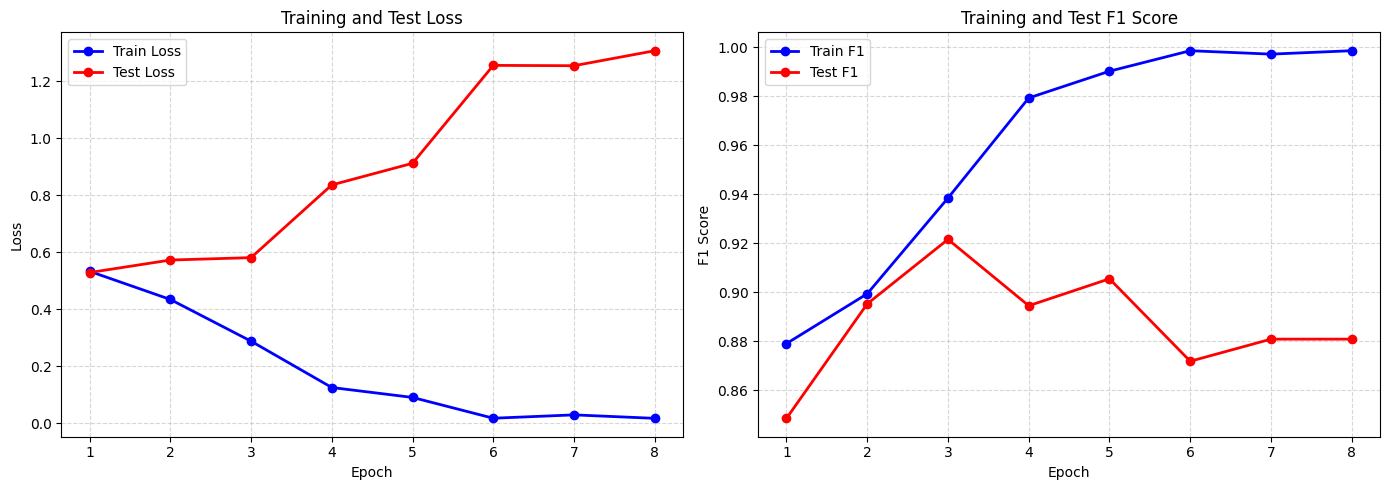

✅ Chart saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled_charts.png

Confusion Matrix:
[[11 14]
 [ 9 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        25
           1       0.86      0.90      0.88        94

    accuracy                           0.81       119
   macro avg       0.70      0.67      0.68       119
weighted avg       0.79      0.81      0.80       119

✅ Evaluation report saved as ./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled_eval.txt


In [16]:
plot_training_history_cm_cr(history,y_true=y_test,y_pred=y_test_pred, classes=["0", "1"], run_name='./final_results/StanceClassification_Bert_MT1_B4_E8_Sampled')


#### Troubleshooting the listing probLem of e-NRC in Sampling Case

In [36]:
X_tr_s, X_val_s, y_tr_s, y_val_s = preprocess_with_expandnrc(
        dfMT1[0:3],
        "./models/nrc_en.json",  
        test_size=0.2,
        random_state=42,
        sample_level= True,  
        device='cpu',
        threshold=0.6
    )
print("continue with training")

h:\moha\NLP\AM\ArgStance\src\data_preprocess_stance.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_id'] = df['topic_id'].fillna('Unknown')
h:\moha\NLP\AM\ArgStance\src\data_preprocess_stance.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['stance'].apply(lambda st: label_encoder.transform(st).tolist())
Device set to use cpu


Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


Computing ExpandNRC features (val): 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]

continue with training


In [43]:
X_tr_s[0:7]

,text,topic_id,nrc_feats
1,"[One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt., And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles., Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners., Of course, first they'd actually need to be caught in the act by public order officers,, but once they have to dig into their pockets, their laziness will sure vanish!]",higher_dog_poo_fines,"[0.12, 0.12, 0.16, 0.12, 0.08, 0.08, 0.16, 0.16, 0.0, 0.0]"
2,"[Health insurance companies should not cover treatment in complementary medicine, unless the promised effect and its medical benefit have been concretely proven., Yet this very proof is lacking in most cases., Patients do often report relief of their complaints after such treatments., But as long as it is unclear as to how this works, the funds should rather be spent on therapies where one knows with certainty.]",health_insurance_cover_complementary_medicine,"[0.08450704225352113, 0.18309859154929578, 0.08450704225352113, 0.18309859154929578, 0.09859154929577464, 0.08450704225352113, 0.08450704225352113, 0.19718309859154928, 0.0, 0.0]"


In [42]:
y_tr_s

1    [1, 1, 1, 0, 1]
2    [1, 0, 1, 0, 1]
Name: label, dtype: object

In [38]:
model, history, y_test_pred= train_model(
    X_train=(X_tr_s['text'].tolist(), X_tr_s['topic_id'].tolist(), X_tr_s['nrc_feats'].tolist()),
    y_train=y_tr_s.tolist(),
    X_test=(X_val_s['text'].tolist(), X_val_s['topic_id'].tolist(), X_val_s['nrc_feats'].tolist()),
    y_test=y_val_s.tolist(),
    batch_size=4,
    epochs=2,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    sample_level=True,
    model_name='bert-base-uncased',  # or any HuggingFace model like 'roberta-base'
    saved_model_path='./results/SC_Bert_MT1_B4_E2_eNRC_Sampled.pt'
)


Model architecture:
StanceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

Epoch 1/2:   0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

# MT2